## Importing the modules

In [150]:
import pandas as pd
import numpy as np
import json
import csv
import pandas as pd
import datetime
import time
import requests
import shutil
import os
from datetime import timedelta, date

## Importing files

In [52]:
lotion_data = pd.read_csv('lotion_data.csv')
beer_data = pd.read_csv('beer_data.csv')
soup_data = pd.read_csv('soup_data.csv')
sunscreen_data = pd.read_csv('sunscreen_data.csv')
soft_drink_data = pd.read_csv('soft_drink_data.csv')
lawn_garden_data = pd.read_csv('lawn_garden_data.csv')
cough_cold_medecin_data = pd.read_csv('cough_cold_medecin_data.csv')
coffee_data = pd.read_csv('coffee_data.csv')
bottled_water_data = pd.read_csv('bottled_water_data.csv')

In [4]:
print 'lotion data', lotion_data.shape
print 'beer_data', beer_data.shape
print 'soup_data', soup_data.shape
print 'sunscreen_data', sunscreen_data.shape
print 'soft_drink_data', soft_drink_data.shape
print 'lawn_garden_data', lawn_garden_data.shape
print 'cough_cold_medecin_data', cough_cold_medecin_data.shape
print 'coffee_data', coffee_data.shape
print 'bottled_water_data', bottled_water_data.shape


lotion data (1560, 12)
beer_data (1560, 12)
soup_data (1560, 12)
sunscreen_data (1560, 12)
soft_drink_data (1560, 12)
lawn_garden_data (1560, 12)
cough_cold_medecin_data (1560, 12)
coffee_data (1560, 12)
bottled_water_data (1560, 12)


## The schema of a file

In [151]:
bottled_water_data.head(5)

,Id,Date,Month,City,State,BottledWaterUnits,BottledWaterPrice,Bottledlag1,Bottledlag2,Bottledlag3,Bottledlag4,Bottledlag52
0,1,6/20/2009,6,Atlanta,GA,1608852,2.25,NaN,NaN,NaN,NaN,NaN
1,2,6/27/2009,6,Atlanta,GA,1634992,2.29,1608852,NaN,NaN,NaN,NaN
2,3,7/4/2009,7,Atlanta,GA,1763773,2.22,1634992,1608852,NaN,NaN,NaN
3,4,7/11/2009,7,Atlanta,GA,1505492,2.16,1763773,1634992,1608852,NaN,NaN
4,5,7/18/2009,7,Atlanta,GA,1823141,1.96,1505492,1763773,1634992,1608852,NaN


### The number of unique cities in the data 

In [7]:
bottled_water_data.City.unique()

array(['Atlanta', 'Boston', 'Chicago', 'Dallas', 'Detroit', 'Los Angeles',
       'Minneapolis', 'New York City', 'Phoenix', 'Seattle'], dtype=object)

### The number of unique features

1. Temperature
2. Humidity
3. Raining
4. Snow
5. Severe Weather Warning
6. Air Quality
7. UV index 
8. Pollen

#Goal 

1. See the correlation between products' sales and weather attributes
2. Define trigger events
3. What are the businees objectives?
    1. price optimization based on trigger events
    2. promotions to increase revenue on trigger events
    3. inventory based on weahter predictions
  

In [15]:
import requests

### Function to get latitude and longitude from the city

In [8]:
apiKey = 'd972da81e1ce2f854f9a5560ffb6f243'
def latlang(city):
    lat = requests.get('http://api.weather.com/v2/location?address=' + city + '&language=en-US&format=json&'
             + 'apiKey=d972da81e1ce2f854f9a5560ffb6f243').json()['addresses'][0]['latitude']
    lon = requests.get('http://api.weather.com/v2/location?address=' + city + '&language=en-US&format=json&'
             + 'apiKey=d972da81e1ce2f854f9a5560ffb6f243').json()['addresses'][0]['longitude']
    return lat, lon


### Function to get weather information from city from a given start date to a end date

In [78]:
def weatherInformation(city, startDate, endDate):
    lat, lon = cityLatLang[city]['lat'], cityLatLang[city]['lon']
    return requests.get('http://api.weather.com/v1/geocode/'+
                                          str(lat) + '/' + str(lon) + 
                                          '/observations/historical.json?apiKey=' + 
                                          apiKey + '&units=m&startDate=' + 
                                          startDate.strftime("%Y%m%d")+ '&endDate=' + 
                                          endDate.strftime("%Y%m%d")).json()


### Averaging the features 

In [147]:
def avgWeatherFeature(feature, city, startDate, endDate):
    featureValue = []
    rawDict = weatherInformation(city, startDate, endDate)
    try:
        obs = rawDict['observations']
        for o in obs:
            try:
                featureValue.append(o[feature])
            except:
                pass
        return sum(featureValue)/float(len(featureValue)+1)
    except:
        return np.nan



In [124]:
def getDates(start_date, end_date, delta):
    '''
    start_date: starting date in format YYYYMMDD
    end_date: end date in format YYYYMMDD
    delta: an integer; the interval between start_date and end_date
    '''
    from datetime import timedelta, date
    delta = delta 
    #Convert dates to date format
    s = datetime.date(int(str(start_date)[:4]),int(str(start_date)[4:6]),int(str(start_date)[6:]))
    e = datetime.date(int(str(end_date)[:4]),int(str(end_date)[4:6]),int(str(end_date)[6:]))

    #Set delta
    if (int(delta) > 30 or int(delta) < 1):
        raise ValueError('Error: delta out of range. 1 <= delta <= 30')
    else:
        delta = timedelta(days=int(delta))

    days= []
    day_from = s
    while (day_from) < e:
        day_to = day_from + delta
        days.append((day_from,day_to))
        day_from += delta
    return days

In [125]:
dates = getDates('20090613', '20120609', 7)
cities = bottled_water_data.City.unique()
npDates = np.asarray(dates)
npDatesRepeat = npDates.repeat(10, axis=0)

In [160]:
df_city_dates = pd.DataFrame({'city': bottled_water_data.City,
                              'startDate': npDatesRepeat[:,0],
                              'endDate': npDatesRepeat[:,1]                              
                              })
cityLatLang = dict((city, {'lat':latlang(city)[0], 'lon':latlang(city)[1]}) for 
                   city in cities)

In [127]:
import time

## Keyword for weather features

1. Humidity = rh (optional)
2. Air Quality = qualifier_svrty (optional)
3. Raining = precip_hrly (optional)
4. Snow = snow_hrly (optional)
5. precip_hrly has a range of 0.00 to 99.99 (optional)
6. snow_hrly has a range of 0 to 15 (optional)
7. UV Index = uv_index (optional)
8. Raining is precip_total 

In [179]:
t = time.time()
df_city_dates['temperature'] = (df_city_dates
                                .apply(lambda x: avgWeatherFeature('temp', x['city'],
                                                            x['startDate'], x['endDate']), axis=1))
df_city_dates['humidity'] = (df_city_dates
                             .apply(lambda x: avgWeatherFeature('rh', x['city'],
                                                            x['startDate'], x['endDate']), axis=1))
df_city_dates['airQuality'] = (df_city_dates
                               .apply(lambda x: avgWeatherFeature('qualifier_svrty', x['city'],
                                                            x['startDate'], x['endDate']), axis=1))
df_city_dates['raining'] = (df_city_dates
                         .apply(lambda x: avgWeatherFeature('precip_hrly', x['city'],
                                                            x['startDate'], x['endDate']), axis=1))
df_city_dates['snowing'] = (df_city_dates
                         .apply(lambda x: avgWeatherFeature('snow_hrly', x['city'],
                                                            x['startDate'], x['endDate']), axis=1))
print time.time() - t 

1356.67402601


In [24]:
bottleWaterMerge = bottled_water_data.merge(df_city_dates[df_city_dates.columns[3:-3]], 
                                             left_index=True, right_index=True)

In [13]:
def addFeature(df, feature):
    uniqueCity = df.City.unique()
    avgFeatures = dict([(city, avgWeatherFeature(feature, city)) for city in uniqueCity])
    return avgFeatures
    

In [127]:
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [229]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [128]:
data_X = bottleWaterMerge[['temperature', 'humidity', 'BottledWaterPrice']]
data_y = bottleWaterMerge['BottledWaterUnits']
data_y = data_y[np.logical_not(np.any(np.isnan(data_X), axis=1))]
data_y = data_y/np.max(data_y)
data_X = data_X.dropna()
data_X_scale = data_X.apply(lambda x: MinMaxScaler().fit_transform(x))

In [152]:
#Testing a linear regressor
# linearRegression = LinearRegression()
# linearRegression.fit(data_X_scale, data_y)
# linearRegression.coef_
# linearRegression.intercept_

## Getting a complete list of features

In [211]:
completeFeature = pd.read_csv(open('/resources/completeFeatures.csv'))

In [212]:
completeFeature = completeFeature[['fog'] + completeFeature.columns[3:].tolist()]

## Plotting the humidity features

In [213]:
humidity = [float(x) if str(x) != "<ufunc 'isnan'>" else np.nan for x in completeFeature.maxhumidity ]

In [220]:
lagColumns = bottled_water_data.columns[-5:].tolist()

array([ 87.,  91.,  80., ...,  90.,  90.,  90.])

In [236]:
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):   
    y = bottled_water_data['BottledWaterUnits'].values[np.where(np.logical_not(np.isnan(humidity)))] 
    x = np.asarray(humidity)[np.where(np.logical_not(np.isnan(humidity)))] 
    print np.corrcoef(x, y)

[[ 1.         -0.18455166]
 [-0.18455166  1.        ]]
[[ 1.         -0.18455166]
 [-0.18455166  1.        ]]
[[ 1.         -0.18455166]
 [-0.18455166  1.        ]]
[[ 1.         -0.18455166]
 [-0.18455166  1.        ]]
[[ 1.         -0.18455166]
 [-0.18455166  1.        ]]
[[ 1.         -0.18455166]
 [-0.18455166  1.        ]]


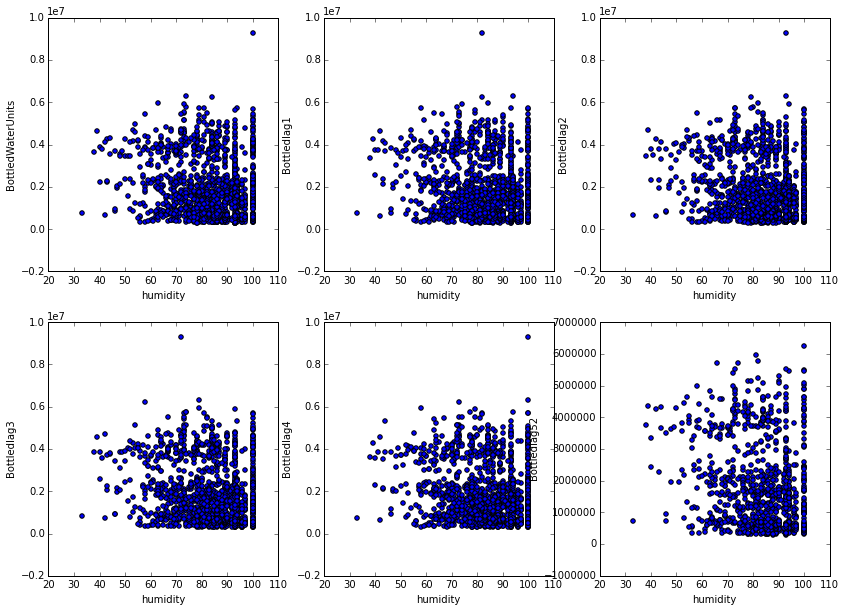

In [219]:
figsize(14,10)
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):
    plt.subplot(2,3,i+1)
    plt.scatter(humidity, bottled_water_data[col_name])
    plt.xlabel('humidity')
    plt.ylabel(col_name)

## There doesn't seem a correlation between humidity and sales.

## Plotting the pressure features

In [240]:
dfp = pd.DataFrame({'pressure':pressure, 'sales': bottled_water_data['BottledWaterUnits']})

In [243]:
dfp['p_range'] = np.logical_and(dfp.pressure > 29.8, dfp.pressure  < 30.2)

In [247]:
dfp.groupby(['p_range']).agg(mean)

,pressure,sales
p_range,,
False,30.006921,1495001
True,29.988056,1993223


In [225]:
pressure = [float(x) if str(x) != "<ufunc 'isnan'>" else np.nan for x in completeFeature.meanpressurei ]

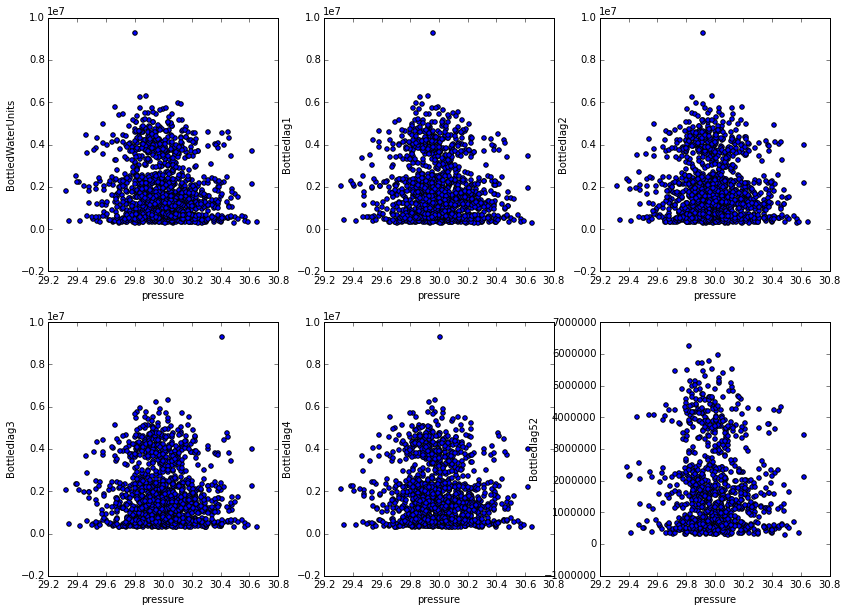

In [226]:
figsize(14,10)
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):
    plt.subplot(2,3,i+1)
    plt.scatter(pressure, bottled_water_data[col_name])
    plt.xlabel('pressure')
    plt.ylabel(col_name)

In [238]:
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):   
    y = bottled_water_data['BottledWaterUnits'].values[np.where(np.logical_not(np.isnan(pressure)))] 
    x = np.asarray(pressure)[np.where(np.logical_not(np.isnan(pressure)))]
    print np.corrcoef(x, y)

[[ 1.         -0.10413857]
 [-0.10413857  1.        ]]
[[ 1.         -0.10413857]
 [-0.10413857  1.        ]]
[[ 1.         -0.10413857]
 [-0.10413857  1.        ]]
[[ 1.         -0.10413857]
 [-0.10413857  1.        ]]
[[ 1.         -0.10413857]
 [-0.10413857  1.        ]]
[[ 1.         -0.10413857]
 [-0.10413857  1.        ]]


## It seems when pressure is around 30 bar, the water sales are high.

In [161]:
from collections import defaultdict

In [228]:
temperature = [float(x) if str(x) != "<ufunc 'isnan'>" else np.nan for x in completeFeature.meantempi ]

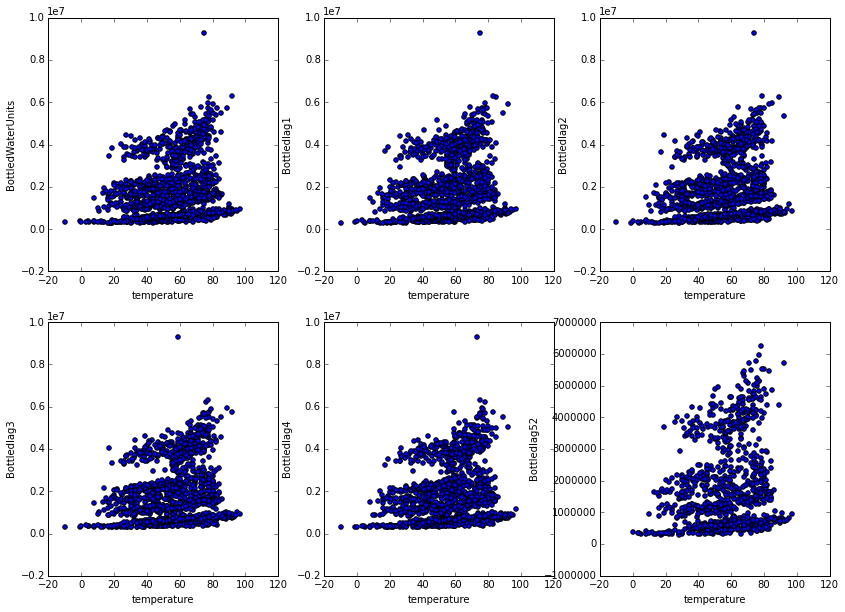

In [231]:
figsize(14,10)
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):
    plt.subplot(2,3,i+1)
    plt.scatter(temperature, bottled_water_data[col_name])
    plt.xlabel('temperature')
    plt.ylabel(col_name)

In [248]:
beer_data.columns

Index([u'Unnamed: 0', u'Date', u'Month', u'City', u'State', u'BeerUnits', u'BeerPrice', u'Beerlag1', u'Beerlag2', u'Beerlag3', u'Beerlag4', u'Beerlag52'], dtype='object')

In [285]:
lagColumnslawn = soup_data.columns[-5:].tolist()

In [282]:
temperature = [float(x) if str(x) != "<ufunc 'isnan'>" else np.nan for x in completeFeature.meantempi ]

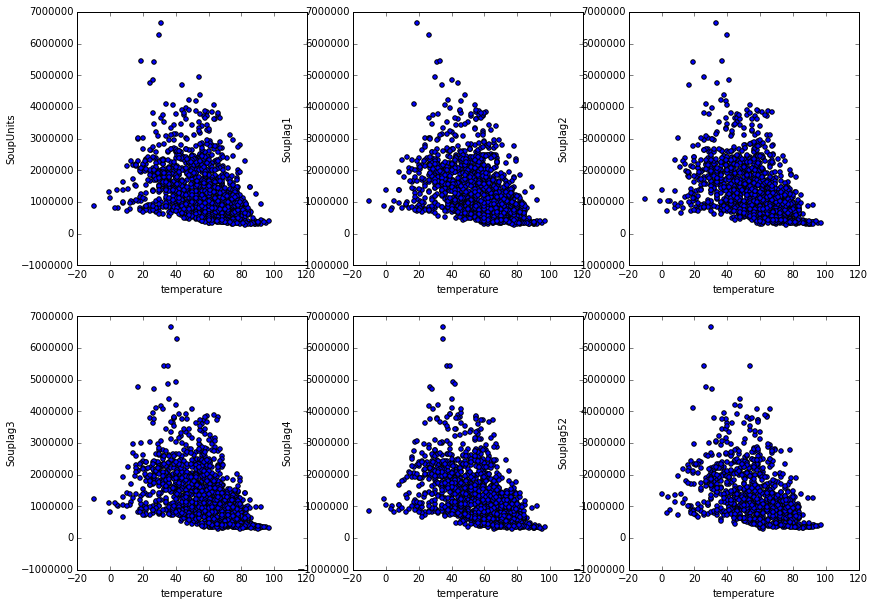

In [287]:
figsize(14,10)
for i, col_name in enumerate(['SoupUnits'] + lagColumnslawn):
    try:
        plt.subplot(2,3,i+1)
        plt.scatter(temperature, soup_data[col_name])
        plt.xlabel('temperature')
        plt.ylabel(col_name)
    except:
        pass

In [280]:
cough_cold_medecin_data.columns

Index([u'Id', u'Date', u'Month', u'City', u'State', u'CoughUnits', u'CoughPrice', u'Coughlag1', u'Coughlag2', u'Coughlag3', u'Coughlag4', u'Coughlag52'], dtype='object')

In [239]:
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):   
    y = bottled_water_data['BottledWaterUnits'].values[np.where(np.logical_not(np.isnan(temperature)))] 
    x = np.asarray(temperature)[np.where(np.logical_not(np.isnan(temperature)))]
    print np.corrcoef(x, y)

[[ 1.          0.22958429]
 [ 0.22958429  1.        ]]
[[ 1.          0.22958429]
 [ 0.22958429  1.        ]]
[[ 1.          0.22958429]
 [ 0.22958429  1.        ]]
[[ 1.          0.22958429]
 [ 0.22958429  1.        ]]
[[ 1.          0.22958429]
 [ 0.22958429  1.        ]]
[[ 1.          0.22958429]
 [ 0.22958429  1.        ]]


## We can see an increase in sales as the temperature increases. 

In [241]:
precipitation = [float(x) if (str(x) != 'T') and (str(x) != "<ufunc 'isnan'>" )
                 else np.nan for x in completeFeature.precipi ]

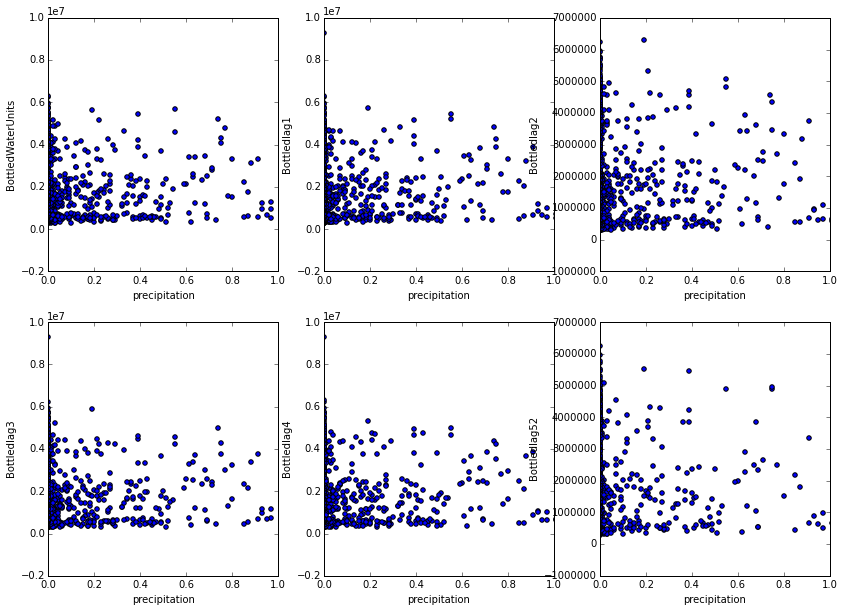

In [168]:
figsize(14,10)
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):
    plt.subplot(2,3,i+1)
    plt.scatter(precipitation, bottled_water_data[col_name])
    plt.xlim([0,1])
    plt.xlabel('precipitation')
    plt.ylabel(col_name)

## There seems no correlation between precipitation and sales.

In [244]:
snow = [float(x) if (str(x) != 'T') and (str(x) != "<ufunc 'isnan'>" )
                 else np.nan for x in completeFeature.snow ]

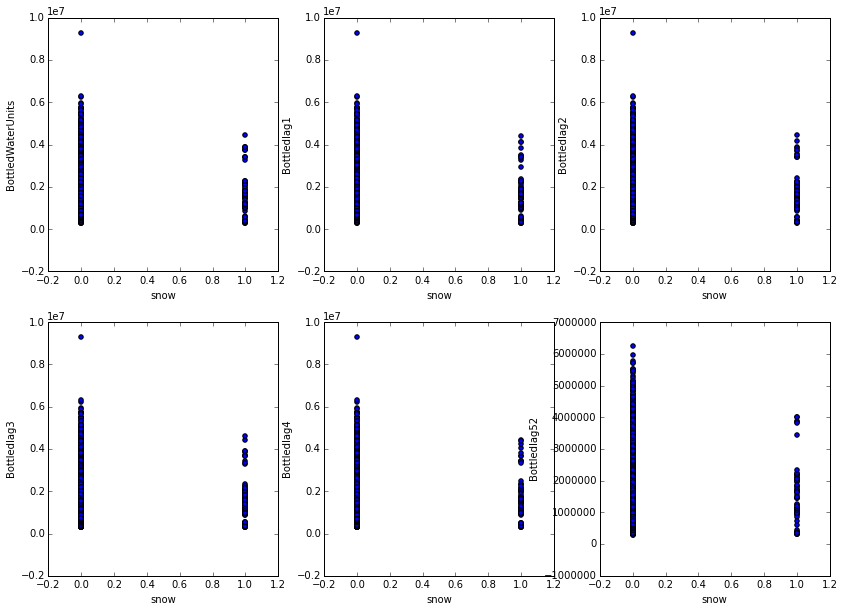

In [250]:
figsize(14,10)
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):
    plt.subplot(2,3,i+1)
    plt.scatter(snow, bottled_water_data[col_name])
    plt.xlabel('snow')
    plt.ylabel(col_name)

## Snow is affecting the water sales.

In [248]:
rain = [float(x) if (str(x) != 'T') and (str(x) != "<ufunc 'isnan'>" )
                 else np.nan for x in completeFeature.rain ]

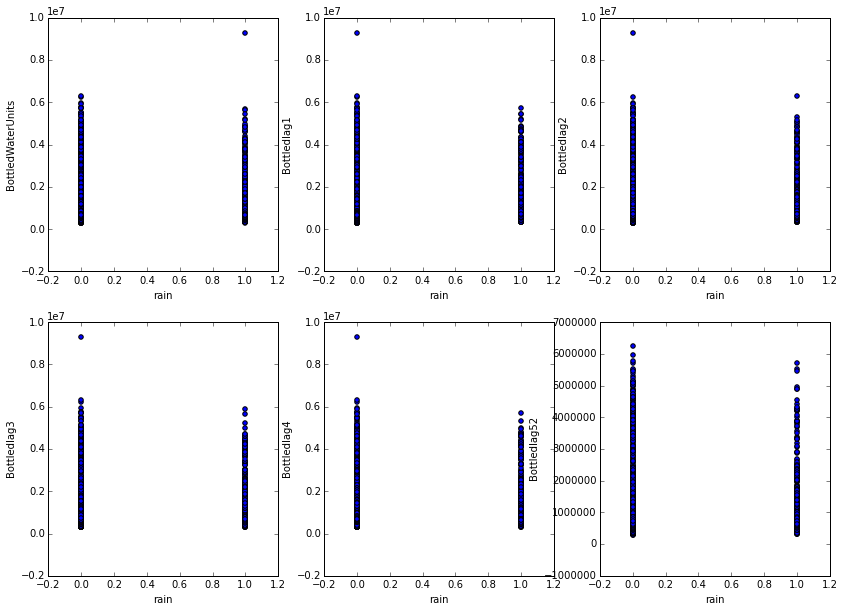

In [251]:
figsize(14,10)
for i, col_name in enumerate(['BottledWaterUnits'] + lagColumns):
    plt.subplot(2,3,i+1)
    plt.scatter(rain, bottled_water_data[col_name])
    plt.xlabel('rain')
    plt.ylabel(col_name)

### Rain probably does not have any impact.

In [53]:
data_complete_X = pd.DataFrame({'temperature':temperature, 'pressure': pressure, 
                               'snow': snow} )

In [57]:
data_complete_y = bottled_water_data[['BottledWaterUnits']+bottled_water_data.columns[-5:].tolist()]

In [61]:
data_combine = data_complete_X.merge(data_complete_y, left_index=True, right_index=True)

## Building a random forest model for predicting the sales

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
reg = RandomForestRegressor()

### Predicting the purchase of the week

In [69]:
data_first_week = data_combine[data_combine.columns[:4]].dropna()

### Dividing the data for training, cross validation, and testing

In [73]:
from sklearn.cross_validation import KFold

In [77]:
kf = KFold(data_first_week.shape[0], shuffle = True)

### Grid search for finding the best parameter for random forest

In [78]:
from sklearn.grid_search import GridSearchCV

** Setting the parameters for cross validation **

In [80]:
tuned_parameters = [{'n_estimators':range(10,30,2), 'max_depth':range(5,10,2)}]

In [125]:
regCv = GridSearchCV(reg, tuned_parameters, cv=5,  scoring='r2')

In [133]:
for train, test in kf:
    data_train, data_test = data_first_week.iloc[train], data_first_week.iloc[test]
    regCv.fit(data_train[['pressure', 'snow', 'temperature']], data_train['BottledWaterUnits'])
    print regCv.score(data_test[['pressure', 'snow', 'temperature']], data_test['BottledWaterUnits'])

0.0844354548277
0.0433235133919
0.0848000119418


/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


## We can see that Random Forest Algorithm is performing better than a naive algorithm that always predicts the mean.

In [149]:
data_second_week = data_combine[data_combine.columns[:5]].dropna()
kf = KFold(data_second_week.shape[0], shuffle = True)
for train, test in kf:
    data_train, data_test = data_second_week.iloc[train], data_second_week.iloc[test]
    regCv.fit(data_train[['pressure', 'snow', 'temperature', 'Bottledlag1']], data_train['BottledWaterUnits'])
    print regCv.score(data_test[['pressure', 'snow', 'temperature', 'Bottledlag1']], data_test['BottledWaterUnits'])

0.946497245598
0.955008050333
0.973659143188


##  After incorporating the historical data with the weather data,  its possible to produce more accurate prediction

In [145]:
data_combine.columns

Index([u'pressure', u'snow', u'temperature', u'BottledWaterUnits', u'Bottledlag1', u'Bottledlag2', u'Bottledlag3', u'Bottledlag4', u'Bottledlag52'], dtype='object')

## Best parameters for cross validation

In [169]:
regCv.best_params_

{'max_depth': 5, 'n_estimators': 20}

## An online algorithm

In [171]:
class ContextualMultiarmBandit(object):
    def __init__(self):
        self.arms = {}
        self.RHO = 10**-6
        self.D = 0
        
    def alpha(self, rho):
        '''
        Returns alpha constant based on rho param for the UCB algorithm.
        
        Arguments: 
         - ``rho``: Rho parameter in float format
        '''
        return 1.0 + math.sqrt(math.log(2.0/rho)/2.0)
        
    def payoff(self, o, x, a_inv, rho):
        '''
        Calculate arm payoff based on arm parameters.
        
        Arguments: 
         - ``o``: A^-1 * b numpy array matrix
         - ``x``: Context vector x numpy array vector
         - ``a_inv``: A^-1  numpy array matrix
         - ``rho``: rho float parameter 
        '''    
        temp = np.dot(x.T, a_inv)    
        p = np.dot(o.T, x) + self.alpha(rho) * math.sqrt(np.dot(temp, x))
        return p[0][0]
    
    def arm_payoff(self, arm, x, rho):
        '''
        Calculate payoff for arm in context, with rho.  
        
        Arguments: 
         - ``arm``: arm dict
         - ``x``: Context vector x numpy array vector
         - ``rho``: rho float parameter    
        '''    
        a_inv = arm['a_inv']    
        o = np.dot(a_inv, arm['b'])
        return self.payoff(o, x, a_inv, rho)
        
    def update_a(self, a, context):
        '''
        Update A matrix of arm based on input context.  
        
        Arguments: 
         - ``a``: A  numpy array matrix
         - ``context``: Context vector as numpy array vector  
        '''    
        return a + np.dot(context, context.T)
    
    
    def update_b(self, b, context, reward):
        '''
        Update b vector of arm based on input context and reward.  
        
        Arguments: 
         - ``b``: A  numpy array vector
         - ``context``: Context vector as numpy array vector  
         - ``reward``: Observer reward value as float
        '''    
        if reward != 0:
            return b + reward * context
        else:
            return b
            
    def init(self, D, ARMS):
        '''    
        Initialize algorithm with input dimension D, arms ARMS.    
    
        Arguments: 
         - ``D``: Input dimensionality as int
         - ``ARMS``: List of arm names       
        '''        
        init_a = np.diag(np.ones(D),0) #Design matrix
        init_b = np.zeros((D,1)) #reward matrix
        a_inv = linalg.inv(init_a)
        self.arms = dict([ (a, {'a' : init_a, 
                                'a_inv': a_inv, 
                                'b' : init_b, 
                                'total_reward' : 0.0
                                }) for a in ARMS 
                                ])
    
    def payoffs(self, x):
        '''
        Return arm payoffs in context x
        
        Arguments: 
         - ``x``: Input context as numpy array vector
         - ``arms``: List of arm dicts    
        '''
        return [(self.arm_payoff(self.arms[arm], x, self.RHO), arm) for arm in self.arms]
            
    def best_arm(self, x):
        '''
        Return best arm index.
        
        Arguments: 
         - ``x``: Input context as numpy array vector
         - ``arms``: List of arm dicts    
        '''    
        poffs = self.payoffs(x)
        s = sorted(poffs, reverse = True)
        return map(lambda s:s[1], s)
        
        
    def observe_and_update(self, context, reward, best_arm):
        '''
        Observe context, take action based on best arm and observe reward. 
        Update arm parameters.
        
        Arguments: 
         - ``context``: Input context as numpy array vector
         - ``reward``: Float valued reward
         - ``arms``: List of arm dicts
         - ``best_arm``: Best arm index as int
        '''        
        
        a = self.arms[best_arm]['a']
        b = self.arms[best_arm]['b']
                           
        self.arms[best_arm]['a'] = self.update_a(a, context)
        self.arms[best_arm]['b'] = self.update_b(b, context, reward)
        self.arms[best_arm]['a_inv'] = linalg.inv(self.arms[best_arm]['a'])
        self.arms[best_arm]['total_reward'] += reward  
    
    def total_reward(self):
        '''
        Float valued total reward accumulated so far.

        Arguments: 
         - ``arms``: List of arm dicts    
         '''
        return sum(map(lambda d: d['total_reward'], self.arms.values()))


*** Assume that we don't know how the sales of Sunscreen is going to afftect by the temperature. We have modeled here an online algorithm to learn the behavior of the Sunscreen sales.

** We are using the contextual Bandit Algorithm and We are using the real data for testing the algorithm.

    > Assume that there is a shop owner. He wants to decide how much Sunscreen, he wants to buy according to the weather condition. To help this shop owner, our algorithm initially make a random guess and the shop owner buy the sunscreen suggested by the algorithm. After making this decision, algorithm observes the real demand and it learns from the difference.  

In [208]:
data_complete_X = pd.DataFrame({'temperature':temperature, 'pressure': pressure, 
                               'snow': snow} )
data_complete_y = sunscreen_data[['SunscreenUnits']+sunscreen_data.columns[-5:].tolist()]

data_combine = data_complete_X.merge(data_complete_y, left_index=True, right_index=True)

In [209]:
ARMS = ['low', 'high']
data_combine['discrete'] = data_combine.SunscreenUnits > data_combine.SunscreenUnits.median()

In [288]:
def test():
    D = 4
      
    avg_rewards = np.zeros(T)
    ucb.init(D, ARMS)
    s = -1
    for ind, row in data_combine.iterrows():         
        context = [1, row['pressure'], row['snow'], row['temperature']]
        correct = ARMS[int(row['discrete'])]
        context = np.asarray(context).reshape(4,1)
        best = ucb.best_arm(context)[0]     
        if best == correct:            
            reward = 1.0
        else:
            reward = 0.0
        s += 1
        # print best, correct
        ucb.observe_and_update(context, reward, best)
        avg_rewards[s] = avg_rewards[s]+ucb.total_reward()/float(s+1)
    plt.plot(avg_rewards)   
    plt.xlabel('Number of learning')
    plt.ylabel('Running average rewards')
    plt.grid()
    plt.show()


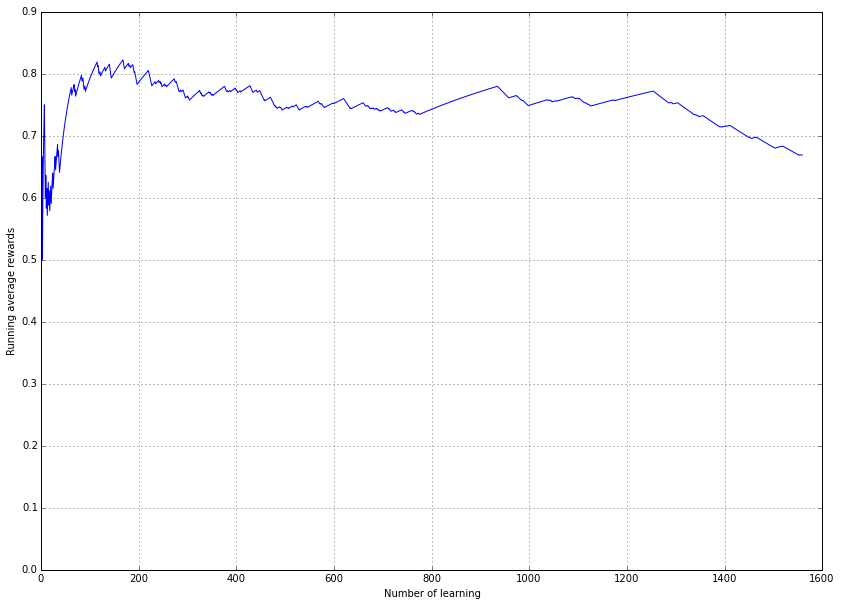

In [289]:
T = data_combine.shape[0]
ucb = ContextualMultiarmBandit()
test()

## Our algorithm is performing much better than a random selection algorithm.